In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf as _acf, pacf as _pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Union, List, Dict, Any

In [3]:
df = pd.read_csv('hourly_summary.csv',parse_dates=['device_time'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   device_time     933 non-null    datetime64[ns]
 1   humidity        933 non-null    float64       
 2   temperature     933 non-null    float64       
 3   hour            933 non-null    int64         
 4   Temp_MA_2       932 non-null    float64       
 5   Humidity_MA_2   932 non-null    float64       
 6   Temp_rate       931 non-null    float64       
 7   Humidity_rate   931 non-null    float64       
 8   Temp_phase      933 non-null    object        
 9   Humidity_phase  933 non-null    object        
 10  daytime_labels  933 non-null    object        
 11  Temp_group      933 non-null    int64         
 12  Humidity_group  933 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 94.9+ KB


In [5]:
df.head()

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels,Temp_group,Humidity_group
0,2025-10-09 00:00:00,79.8,27.9,0,NaN,NaN,NaN,NaN,Neutral,Moderate,late night,1,1
1,2025-10-09 01:00:00,81.1,27.6,1,27.75,80.45,NaN,NaN,Neutral,Moderate,late night,1,1
2,2025-10-09 02:00:00,81.6,27.5,2,27.55,81.35,-0.20,0.90,Cooling,Moistening,late night,2,2
3,2025-10-09 03:00:00,82.0,27.5,3,27.50,81.80,-0.05,0.45,Cooling,Moistening,late night,2,2
4,2025-10-09 04:00:00,82.2,27.4,4,27.45,82.10,-0.05,0.30,Cooling,Moistening,early morning,2,2


In [6]:
df.head()

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels,Temp_group,Humidity_group
0,2025-10-09 00:00:00,79.8,27.9,0,NaN,NaN,NaN,NaN,Neutral,Moderate,late night,1,1
1,2025-10-09 01:00:00,81.1,27.6,1,27.75,80.45,NaN,NaN,Neutral,Moderate,late night,1,1
2,2025-10-09 02:00:00,81.6,27.5,2,27.55,81.35,-0.20,0.90,Cooling,Moistening,late night,2,2
3,2025-10-09 03:00:00,82.0,27.5,3,27.50,81.80,-0.05,0.45,Cooling,Moistening,late night,2,2
4,2025-10-09 04:00:00,82.2,27.4,4,27.45,82.10,-0.05,0.30,Cooling,Moistening,early morning,2,2


In [7]:
df.corr(numeric_only=True)

,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_group,Humidity_group
humidity,1.000000,0.434928,-0.047120,0.428675,0.987349,0.072274,0.232190,-0.660769,-0.650820
temperature,0.434928,1.000000,-0.118410,0.988026,0.446443,0.241014,-0.012913,-0.471631,-0.462889
hour,-0.047120,-0.118410,1.000000,-0.119886,-0.057444,-0.017935,0.121873,0.011422,0.011499
Temp_MA_2,0.428675,0.988026,-0.119886,1.000000,0.442661,0.123401,-0.042609,-0.476871,-0.468003
Humidity_MA_2,0.987349,0.446443,-0.057444,0.442661,1.000000,0.075041,0.118876,-0.668151,-0.658092
Temp_rate,0.072274,0.241014,-0.017935,0.123401,0.075041,1.000000,0.114247,-0.004892,-0.004973
Humidity_rate,0.232190,-0.012913,0.121873,-0.042609,0.118876,0.114247,1.000000,-0.003447,-0.003022
Temp_group,-0.660769,-0.471631,0.011422,-0.476871,-0.668151,-0.004892,-0.003447,1.000000,0.998935
Humidity_group,-0.650820,-0.462889,0.011499,-0.468003,-0.658092,-0.004973,-0.003022,0.998935,1.000000


# Computing Previous (Hour) Features

In [8]:
df["humidity_lag1"] = df["humidity"].shift(1)
df["humidity_lag2"] = df["humidity"].shift(2)
df["humidity_lag3"] = df["humidity"].shift(3)
df['humidity_rate_lag1'] = df['Humidity_rate'].shift(1)
df["temp_lag1"] = df["temperature"].shift(1)

In [9]:
df.corr(numeric_only=True)

,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_group,Humidity_group,humidity_lag1,humidity_lag2,humidity_lag3,humidity_rate_lag1,temp_lag1
humidity,1.000000,0.434928,-0.047120,0.428675,0.987349,0.072274,0.232190,-0.660769,-0.650820,0.949675,0.894351,0.852943,0.210746,0.412233
temperature,0.434928,1.000000,-0.118410,0.988026,0.446443,0.241014,-0.012913,-0.471631,-0.462889,0.446754,0.441425,0.431730,0.033960,0.952349
hour,-0.047120,-0.118410,1.000000,-0.119886,-0.057444,-0.017935,0.121873,0.011422,0.011499,-0.068682,-0.098486,-0.123619,0.128397,-0.119000
Temp_MA_2,0.428675,0.988026,-0.119886,1.000000,0.442661,0.123401,-0.042609,-0.476871,-0.468003,0.445445,0.448797,0.441235,0.010155,0.988005
Humidity_MA_2,0.987349,0.446443,-0.057444,0.442661,1.000000,0.075041,0.118876,-0.668151,-0.658092,0.987328,0.933773,0.884753,0.223875,0.428261
Temp_rate,0.072274,0.241014,-0.017935,0.123401,0.075041,1.000000,0.114247,-0.004892,-0.004973,0.075904,0.019810,-0.025693,0.222408,0.002718
Humidity_rate,0.232190,-0.012913,0.121873,-0.042609,0.118876,0.114247,1.000000,-0.003447,-0.003022,0.002474,-0.227481,-0.207928,0.455479,-0.071312
Temp_group,-0.660769,-0.471631,0.011422,-0.476871,-0.668151,-0.004892,-0.003447,1.000000,0.998935,-0.659420,-0.658222,-0.657129,-0.002048,-0.470658
Humidity_group,-0.650820,-0.462889,0.011499,-0.468003,-0.658092,-0.004973,-0.003022,0.998935,1.000000,-0.649547,-0.648366,-0.647110,-0.002156,-0.461871
humidity_lag1,0.949675,0.446754,-0.068682,0.445445,0.987328,0.075904,0.002474,-0.659420,-0.649547,1.000000,0.949517,0.894064,0.231315,0.433454


In [32]:
def check_acf_pacf(
    df: pd.DataFrame,
    cols: Union[str, List[str]],
    nlags: int = 40,
    alpha: float = 0.05,
    dropna_strategy: str = "drop",   # options: "drop", "ffill", "bfill", "interpolate"
    pacf_method: str = "ywm", # options vary by statsmodels version: "ywunbiased","ywm","ols","ld"
    plot: bool = True,
    figsize: tuple = (12, 6),
    title_prefix: str = "",
    return_data: bool = True,
    acf_fft: bool = False,
    **plot_kwargs
) -> Dict[str, Any]:
    """
    Compute and optionally plot ACF and PACF for one or more series.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing time series columns.
    cols : str or list[str]
        Column name or list of column names to analyse.
    nlags : int
        Number of lags to compute/display.
    alpha : float
        Significance level for confidence intervals (e.g. 0.05 -> 95% CI).
    dropna_strategy : str
        How to handle NA before analysis: "drop", "ffill", "bfill", "interpolate".
    pacf_method : str
        Method passed to statsmodels.pacf for PACF computation.
    plot : bool
        Whether to produce ACF/PACF plots.
    figsize : tuple
        Figure size for each variable's pair of plots.
    title_prefix : str
        Optional prefix added to plot titles.
    return_data : bool
        Return ACF/PACF arrays and summary DataFrame in a dict.
    acf_fft : bool
        Whether to use FFT-based ACF calculation (faster for long series).
    plot_kwargs : dict
        Extra keyword args forwarded to plot_acf / plot_pacf (e.g., lags, zero).
    
    Returns
    -------
    result : dict
        Keys are column names. Each value is a dict with:
          - 'series' : the cleaned pandas.Series used
          - 'acf'    : numpy array of acf values (length nlags+1)
          - 'pacf'   : numpy array of pacf values (length nlags+1)
          - 'acf_ci' : conf interval array (2 x (nlags+1)) if available
          - 'pacf_ci': conf interval for pacf (None if not available)
          - 'table'  : pd.DataFrame with columns ['lag','acf','pacf']
    """

    # Normalize cols to list
    if isinstance(cols, str):
        cols = [cols]

    # validate dropna strategy
    valid_strats = {"drop", "ffill", "bfill", "interpolate"}
    if dropna_strategy not in valid_strats:
        raise ValueError(f"dropna_strategy must be one of {valid_strats}")

    results = {}

    for col in cols:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in dataframe")

        s = df[col]

        # Ensure numeric
        s = pd.to_numeric(s, errors="coerce")

        # Handle missing values
        if dropna_strategy == "drop":
            s_clean = s.dropna()
        elif dropna_strategy == "ffill":
            s_clean = s.fillna(method="ffill").dropna()
        elif dropna_strategy == "bfill":
            s_clean = s.fillna(method="bfill").dropna()
        elif dropna_strategy == "interpolate":
            s_clean = s.interpolate().dropna()
        else:
            s_clean = s.dropna()

        if len(s_clean) < 5:
            raise ValueError(f"Column {col} has too few non-NA samples after cleaning ({len(s_clean)}).")

        # Compute ACF and PACF using statsmodels
        # _acf returns (acf_vals, confint) if alpha provided; set fft param for performance
        acf_vals, acf_ci = _acf(s_clean, nlags=nlags, alpha=alpha, fft=acf_fft)
        # pacf: statsmodels.pacf returns pacf array; conf int is not always returned by pacf function,
        # so we compute pacf alone. Use method parameter to choose algorithm.
        pacf_vals = _pacf(s_clean, nlags=nlags, method=pacf_method)

        # Create table for quick review
        lags = np.arange(len(acf_vals))
        table = pd.DataFrame({
            "lag": lags,
            "acf": acf_vals,
            "pacf": pacf_vals
        })

        results[col] = {
            "series": s_clean,
            "acf": acf_vals,
            "acf_ci": acf_ci,
            "pacf": pacf_vals,
            "pacf_ci": None,
            "table": table
        }

        # Plotting
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=figsize)
            # ACF plot (uses statsmodels plot_acf for correct CI ribbons)
            plot_acf(
                s_clean,
                ax=axes[0],
                lags=nlags,
                alpha=alpha,
                fft=acf_fft,
                **plot_kwargs
            )
            axes[0].set_title(f"{title_prefix}{col} — ACF")

            # PACF plot
            plot_pacf(
                s_clean,
                ax=axes[1],
                lags=nlags,
                alpha=alpha,
                method=pacf_method,
                **plot_kwargs
            )
            axes[1].set_title(f"{title_prefix}{col} — PACF")

            plt.tight_layout()
            plt.show()

    if return_data:
        return results
    else:
        return None

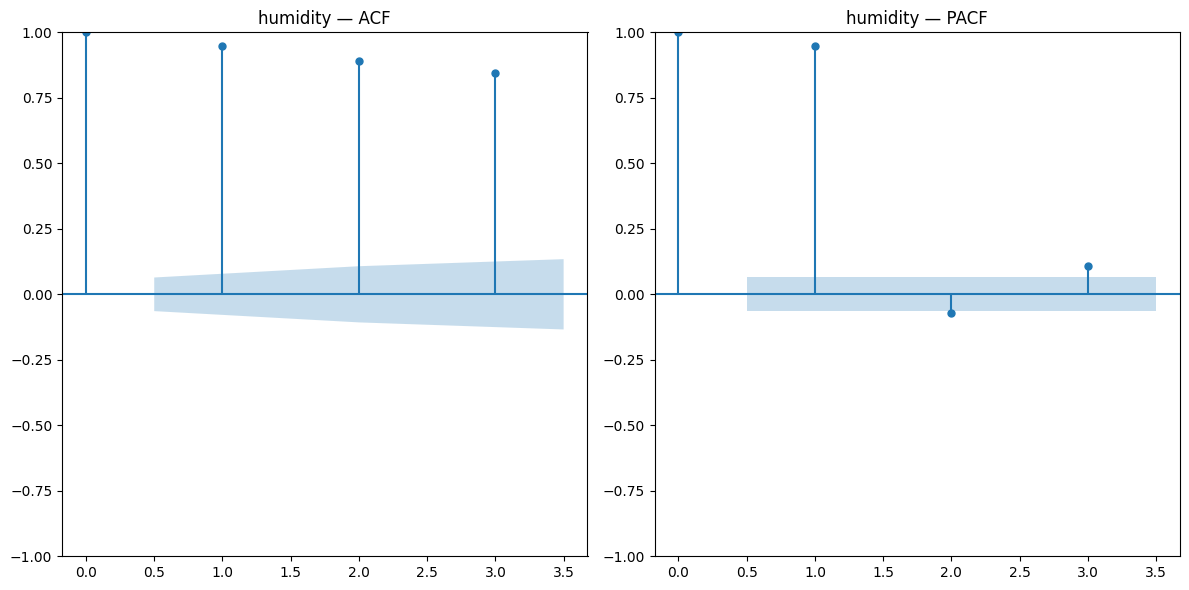

In [35]:
res = check_acf_pacf(df, cols='humidity', nlags=3)

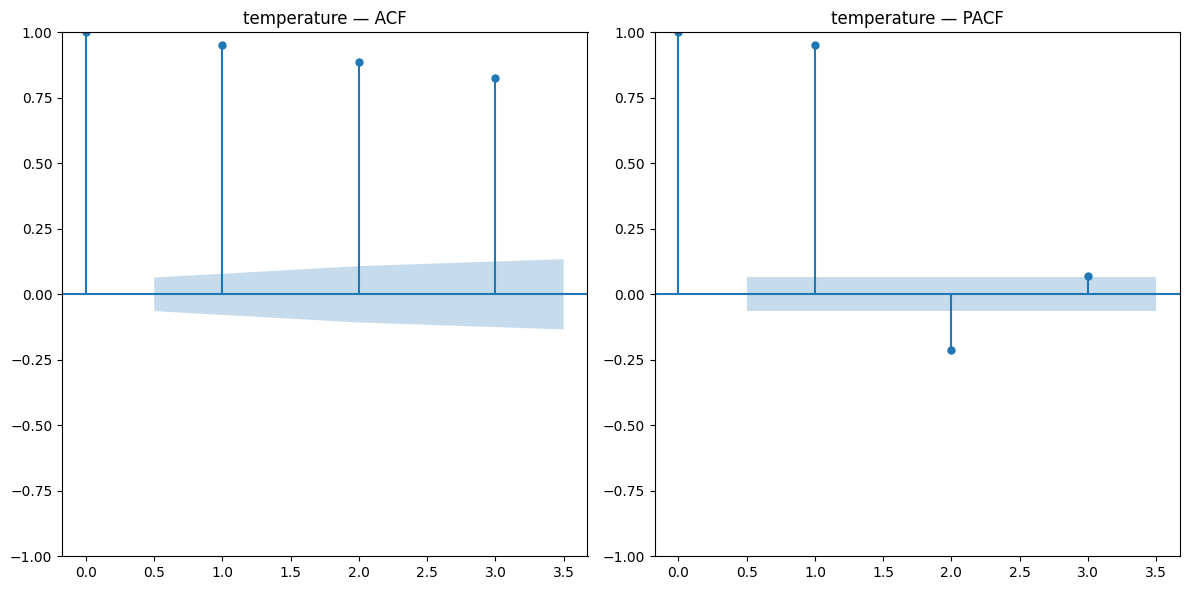

In [36]:
res = check_acf_pacf(df, cols='temperature', nlags=3)

In [43]:
def check_stationarity_adf(
    series: Union[pd.Series, pd.DataFrame],
    col: str = None,
    alpha: float = 0.05,
    print_result: bool = True
):
    """
    Perform the Augmented Dickey-Fuller (ADF) stationarity test and interpret results.

    Parameters
    ----------
    series : pd.Series or pd.DataFrame
        The input time series or dataframe containing the series.
    col : str, optional
        Column name if a DataFrame is passed. Not needed if a Series is passed.
    alpha : float
        Significance level. Default is 0.05 (95% confidence).
    print_result : bool
        Whether to print the interpretation to console.

    Returns
    -------
    Dict[str, Any]
        Dictionary containing ADF statistics, p-value, critical values, and stationarity flag.
    """

    # Extract series
    if isinstance(series, pd.DataFrame):
        if col is None:
            raise ValueError("For DataFrame input, specify the 'col' argument.")
        x = series[col].dropna()
        name = col
    else:
        x = series.dropna()
        name = series.name if series.name else "series"

    # Run ADF test
    result = adfuller(x, autolag="AIC")

    adf_stat = result[0]
    p_value = result[1]
    used_lags = result[2]
    n_obs = result[3]
    critical_values = result[4]

    # Determine stationarity
    is_stationary = p_value < alpha

    if print_result:
        print(f"\nADF Stationarity Test for '{name}':")
        print("---------------------------------------")
        print(f"ADF Statistic : {adf_stat:.4f}")
        print(f"p-value       : {p_value:.4f}")
        print(f"Used lags     : {used_lags}")
        print(f"Observations  : {n_obs}")
        print("Critical Values:")
        for k, v in critical_values.items():
            print(f"   {k}: {v:.4f}")

        # Interpretation
        print("\nInterpretation:")
        if is_stationary:
            print(f"✔ The series **IS STATIONARY** at alpha = {alpha}.")
            print("  → Reject the null hypothesis (unit root).")
            print("  → Mean/variance/autocorrelation are stable.")
        else:
            print(f"✖ The series **IS NOT STATIONARY** at alpha = {alpha}.")
            print("  → Cannot reject the null hypothesis.")
            print("  → Series likely has trend, seasonality, or non-constant variance.")

    return {
        "adf_statistic": adf_stat,
        "p_value": p_value,
        "used_lags": used_lags,
        "n_obs": n_obs,
        "critical_values": critical_values,
        "is_stationary": is_stationary
    }

In [44]:
check_stationarity_adf(df['temperature'])



ADF Stationarity Test for 'temperature':
---------------------------------------
ADF Statistic : -4.3754
p-value       : 0.0003
Used lags     : 5
Observations  : 927
Critical Values:
   1%: -3.4374
   5%: -2.8647
   10%: -2.5684

Interpretation:
✔ The series **IS STATIONARY** at alpha = 0.05.
  → Reject the null hypothesis (unit root).
  → Mean/variance/autocorrelation are stable.


{'adf_statistic': np.float64(-4.375404276590642),
 'p_value': np.float64(0.0003280392248996996),
 'used_lags': 5,
 'n_obs': 927,
 'critical_values': {'1%': np.float64(-3.437423894618058),
  '5%': np.float64(-2.864662884591462),
  '10%': np.float64(-2.5684328157550835)},
 'is_stationary': np.True_}

In [45]:
check_stationarity_adf(df['humidity'])


ADF Stationarity Test for 'humidity':
---------------------------------------
ADF Statistic : -1.0753
p-value       : 0.7248
Used lags     : 21
Observations  : 911
Critical Values:
   1%: -3.4375
   5%: -2.8647
   10%: -2.5685

Interpretation:
✖ The series **IS NOT STATIONARY** at alpha = 0.05.
  → Cannot reject the null hypothesis.
  → Series likely has trend, seasonality, or non-constant variance.


{'adf_statistic': np.float64(-1.0752955789070642),
 'p_value': np.float64(0.7248225380049358),
 'used_lags': 21,
 'n_obs': 911,
 'critical_values': {'1%': np.float64(-3.437548486956221),
  '5%': np.float64(-2.864717822047763),
  '10%': np.float64(-2.5684620784026433)},
 'is_stationary': np.False_}

In [37]:
training_data = df[['temp_lag1','humidity','humidity_lag3','hour','temperature']]

In [38]:
training_data = training_data.dropna()

In [39]:
training_data.corr()

,temp_lag1,humidity,humidity_lag3,hour,temperature
temp_lag1,1.000000,0.412297,0.440168,-0.118283,0.952353
humidity,0.412297,1.000000,0.852943,-0.040146,0.435248
humidity_lag3,0.440168,0.852943,1.000000,-0.123619,0.431730
hour,-0.118283,-0.040146,-0.123619,1.000000,-0.117475
temperature,0.952353,0.435248,0.431730,-0.117475,1.000000


In [14]:
def get_distribution_type(data: pd.DataFrame, feature: str, **kwargs):
    """
    Plot the distribution of a given feature using seaborn.displot.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the feature.
    feature : str
        Column name to plot.
    **kwargs :
        Additional keyword arguments passed to sns.displot().
    """
    try:
        sns.displot(data[feature], **kwargs)
        plt.show()
    except Exception as e:
        print(f"Error plotting feature '{feature}': {e}")
        raise

def plot_relationship(data: pd.DataFrame,col1: str,col2: str,**kwargs):
    """
    Scatter plot showing the relationship between temperature and humidity.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing temperature and humidity columns.
    col1 : str, default='temperature'
        The column name for temperature values.
    col2 : str, default='humidity'
        The column name for humidity values.
    **kwargs :
        Additional keyword arguments passed to plt.scatter().
        Examples: color='red', alpha=0.5, s=20, marker='x'
    """
    try:
        # Default transparency if not given


        plt.figure(figsize=kwargs.pop('figsize', (6, 4)))
        plt.scatter(data[col1], data[col2], **kwargs)
        plt.xlabel(f"{col1.capitalize()} (°C)")
        plt.ylabel(f"{col2.capitalize()} (%)")
        plt.title(f"{col1.capitalize()} vs {col2.capitalize()}")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting {col1} vs {col2}: {e}")
        raise

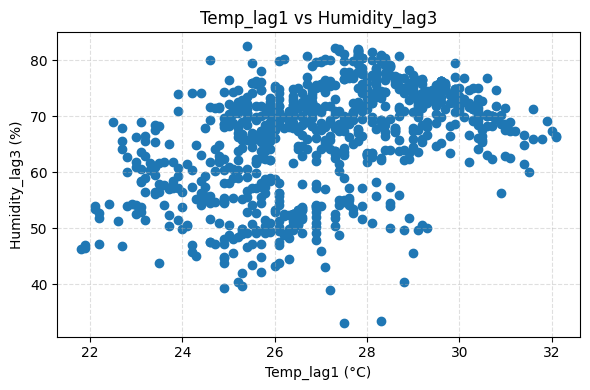

In [15]:
plot_relationship(data=training_data, col1='temp_lag1', col2='humidity_lag3')

In [16]:
x = training_data.drop('humidity',axis=1)
y = training_data['humidity']

In [17]:
x.columns

Index(['temp_lag1', 'humidity_lag3', 'hour'], dtype='object')

In [18]:
train_x, test_x, train_y, test_y = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [19]:
model = RandomForestRegressor()
model.fit(train_x,train_y)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
result_train = model.predict(train_x)

In [21]:
result_test = model.predict(test_x)

In [22]:
print(r2_score(train_y, result_train))

0.9678800322165413


In [23]:
print(r2_score(test_y, result_test))

0.8225176062823565


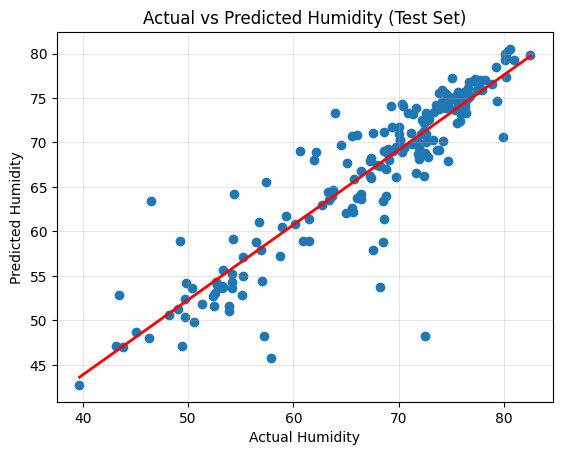

In [24]:
plt.scatter(test_y, result_test)

m, b = np.polyfit(test_y, result_test, 1)   # slope (m) and intercept (b)
x_line = np.linspace(min(test_y), max(test_y), 100)
y_line = m * x_line + b

# Plot the best-fit line
plt.plot(x_line, y_line, linewidth=2, color='red')

plt.xlabel("Actual Humidity")
plt.ylabel("Predicted Humidity")
plt.title("Actual vs Predicted Humidity (Test Set)")
plt.grid(alpha=0.3)
plt.show()

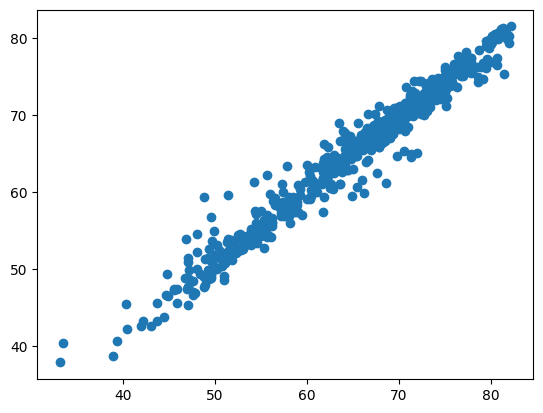

In [25]:
plt.scatter(train_y, result_train)

In [26]:
training_data.head()

,temp_lag1,humidity,humidity_lag3,hour
3,27.5,82.0,79.8,3
4,27.5,82.2,81.1,4
5,27.4,82.5,81.6,5
6,27.4,79.5,82.0,6
7,27.3,54.2,82.2,7


In [27]:
training_data

,temp_lag1,humidity,humidity_lag3,hour
3,27.5,82.0,79.8,3
4,27.5,82.2,81.1,4
5,27.4,82.5,81.6,5
6,27.4,79.5,82.0,6
7,27.3,54.2,82.2,7
...,...,...,...,...
928,26.5,49.1,53.3,9
929,26.0,55.3,53.3,10
930,25.0,51.1,50.6,11
931,25.6,49.7,49.1,12


In [28]:
x.shape

(930, 3)

In [29]:
train_x.shape

(744, 3)

In [30]:
test_x.shape

(186, 3)

In [46]:
df.shape

(933, 18)